In [1]:
import numpy as np
import math
from copy import deepcopy
import sklearn.datasets
from sklearn.svm import SVC
from matplotlib import pyplot as plt

In [2]:
X,y = sklearn.datasets.make_hastie_10_2()
X_train = X[0:8000,:]
y_train = y[0:8000]
X_test = X[8000:,:]
y_test = y[8000:]
X[0]

array([-0.14970521, -0.36131565, -0.32222605,  0.53481632,  0.23873214,
       -0.26958066, -0.3600787 , -0.64613088, -1.06563433, -0.34304205])

# Exercise 1

1. Implement the AdaBoost ensemble algorithm by completing the following code:

In [3]:
#SVC with weight correction, as suggested
class SVC_:
        def __init__(self, kernel="rbf", degree="3"):
            self.svc = SVC(kernel=kernel, degree=degree)

        def fit(self, X,y,sample_weight=None):
            if sample_weight is not None:
                sample_weight = sample_weight * len(X)

            self.svc.fit(X,y,sample_weight=sample_weight)
            return self

        def predict(self, X):
            return self.svc.predict(X)

In [4]:
#utility error function
def calc_error(y_true, y_pred):
    return 0.5 - np.dot(y_true.T, y_pred)/(y_true.size * 2)

In [5]:
class AdaBoost: 
    def __init__(self, _weakModel, _T):
        self.T = _T
        self.weakModel = _weakModel
        self.alphas = []
        self.models = []
        self.errors = []


    def fit(self, X, y, printFreq=True):
        w_start = 1 / len(X_train)  # Distribuzione uniforme dei pesi associati agli esempi [1/|D|]
        self.w = np.zeros(len(X_train))
        # Inizializzazione con valori di default
        self.w.fill(w_start)
        
        partial_pred = np.zeros(y.size)
        
        for t in range(0, self.T): # Itero T volte
            #if (printFreq): print(t)

            weakModelCopy = deepcopy(self.weakModel) #Mantengo i riferimenti del modello originale
            weakModelCopy.fit(X, y, self.w)  # Calcola m_t = A(D, w^t)

            # Calcolo exponential loss di m_t = somma dei pesi delle classificazioni errate (< 0.5 per l'apprendibilità debole)
            error = 0
            y_predict = weakModelCopy.predict(X)  
            for i in range(0, len(X)):
                if y_predict[i] != y[i]:
                    error += self.w[i]
            #ymt = y * y_predict
            #error = np.dot(self.w, (ymt < 0).astype(int))  

            # Calcolo del peso associato alle ipotesi alpha_t = 1/2 ln ( [1-\epsilon] / [\epsilon] )
            alpha = 0.5 * math.log((1 - error) / error)
            
            partial_pred += np.dot(alpha, y_predict)

            # Aggiornamento dell'intero vettore pesi w in funzione di \alpha e della predizione (segno concorde o discorde)    
            #w = w * np.exp(-alpha * y * y_predict)
            #w = w / np.sum(w)
            sum = 0
            for i in range(0, len(X)):
                self.w[i] = self.w[i] * math.exp(-alpha * y[i] * y_predict[i])
                sum += self.w[i]

            #Normalizzazione dei pesi nell'intervallo [0, 1]
            for i in range(0, len(X)):
                self.w[i] = self.w[i] / sum
                
            ensemble_err = calc_error(y, np.sign(partial_pred))
            self.errors.append(ensemble_err)
            self.alphas.append(alpha)
            self.models.append(weakModelCopy)
        return self

    def predict(self, X, printFreq=True):
        preds = np.zeros(X.shape[0])

        for t in range(0, self.T):
            #if (printFreq): print(t)
            a = self.alphas[t]
            m = self.models[t]

            # Voto di maggioranza pesata per \alpha (peso delle ipotesi e non delle istanze mal classificate)
            preds += np.dot(a,m.predict(X))
            preds = np.sign(preds)
        return preds

In the implementation you are free to assume:
- that the problem is a binary classification problem with labels in $\{-1, +1\}$.
- that the weakModel can fit a weighted sample set by means of the call `weakModel.fit(X,y,sample_weight=w)` where `w` is a vector of length $|y|$.

2. Test your implementation on the dataset loaded above and using an SVC with a polynomial kernel. 

In [6]:
from sklearn.metrics import accuracy_score

weakModel = SVC_(kernel="poly", degree=3)
adaboost = AdaBoost(weakModel, 100)#100 iterazioni
adaboost.fit(X_train, y_train)
y_train_pred = adaboost.predict(X_train)
y_test_pred = adaboost.predict(X_test)

print("Accuracy on the Train Set: %s" % accuracy_score(y_train, y_train_pred))
print("Accuracy on the Test Set: %s" % accuracy_score(y_test, y_test_pred))

Accuracy on the Train Set: 0.656125
Accuracy on the Test Set: 0.607


3. evaluate the AdaBoost performances as usual by calculating the classification error and compare it with the classification error of the weak model.


Training Set
 --------------------
Acc: 0.656125 (Error: 0.343875)

Test Set
 --------------------
Acc: 0.607000 (Error: 0.393000)



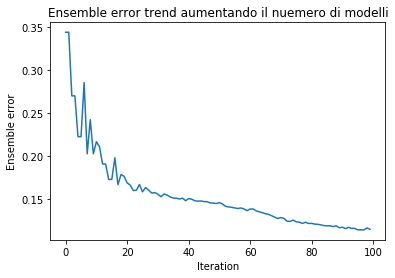

In [7]:
from sklearn.metrics import accuracy_score
print("Training Set\n", "-" * 20)
print("Acc: %5f (Error: %5f)\n" % (accuracy_score(y_train, y_train_pred), calc_error(y_train, y_train_pred)))
print("Test Set\n", "-" * 20)
print("Acc: %5f (Error: %5f)\n" % (accuracy_score(y_test, y_test_pred), calc_error(y_test, y_test_pred)))

xs = np.arange(0, len(adaboost.errors))
plt.plot(xs, adaboost.errors)
plt.xlabel("Iteration")
plt.ylabel("Ensemble error")
plt.title("Ensemble error trend aumentando il nuemero di modelli")
plt.show()

**Note 1**:  
since the labels are bound to be in ${+1, -1}$, the classification error (i.e., the number of incorrectly classified examples over the total number of examples) can be easily computed as:
$$
   error(y,y') = \frac{N - y \cdot y'}{2N} = \frac{1}{2} - \frac{y \cdot y'}{2N},
$$
where $N$ is the total number of examples. The formula can be derived noticing that $y \cdot y'$ calculates the number $N_c$ of examples correctly classified  minus the number $N_{\bar c}$ of examples incorrectly classified. We have then $y \cdot y' = N_c - N_{\bar c}$ and by noticing that $N = N_c + N_{\bar c}$:
$$
   N - y \cdot y' = N_c + N_{\bar c} - N_c + N_{\bar c} = 2 N_{\bar c} \Rightarrow \frac{N - y \cdot y'}{2 N} = \frac{N_{\bar c}}{N}
$$

**Note 2**:
do not forget to deepcopy your base model before fitting it to the new data

**Note 3**:
The SVC model allows specifying weights, but it *does not* work well when weights are normalized (it works well when the weights are larger). The following class takes normalized weights and denormalize them before passing them to the SVC classifier:

```python
    class SVC_:
        def __init__(self, kernel="rbf", degree="3"):
            self.svc = SVC(kernel=kernel, degree=degree)

        def fit(self, X,y,sample_weight=None):
            if sample_weight is not None:
                sample_weight = sample_weight * len(X)

            self.svc.fit(X,y,sample_weight=sample_weight)
            return self

        def predict(self, X):
            return self.svc.predict(X)
```

# Exercise 2

1. Write a weak learner to be used with the AdaBoost algorithm you just wrote. The weak learner that you will implement is the most inaccurate weak learner possible: it basically works by extracting a linear model at random and trying to use that model to classify the examples. Being extracted at random the models it generates do not guarantee that the weighted error $\epsilon_t$ is smaller than $0.5$. The algorithm solves this problem by flipping the decisions whenever it finds out that $\epsilon_t > 0.5$ (i.e., if the weighted error is larger than $0.5$ it reverses the sign of all the weights so that the decision surface stays the same, but the regions where it predicts $+1$ and $-1$ are reversed).

    It shall work as follows:

    - it creates a random linear model by generating the needed weight vector $\mathbf{w}$ at random (**note**: these are the weights of the linear model, they are *NOT* related in any way to the weights of the examples); each weight shall be sampled from U(-1,1);
    - it evaluates the weighted loss $\epsilon_t$ on the given dataset and flip the linear model if $\epsilon_t > 0.5$;
    - at prediction time it predicts +1 if $\mathbf{x} \cdot \mathbf{w} > 0$; it predicts -1 otherwise.

In [8]:
class RandomLinearModel:
    # peso totale degli elementi mal classificati
    def loss(self, y, y_, w):
        #sum = np.sum(w.dot([1 if y_t != y_p else 0 for y_t, y_p in zip(y, y_)]))
        sum = np.dot(w, ((y*y_) < 0).astype(int))
        return sum
        
    def fit(self,X,y,example_weights):
        self.w_ = np.random.uniform(-1, 1, X.shape[1]) # Creo un modello lineare a random con peso tra U(-1,1);
        err = self.loss(y, self.predict(X), example_weights)
        if err > 0.5:           # 0.5 è la condizione necessaria e sufficiente ...
            self.w_ * -1
        return self    
        
    def predict(self,X):
        return [1 if s > 0 else -1 for s in X.dot(self.w_)]

2. Learn an AdaBoost model using the RandomLinearModel weak learner printing every $K$ iterations the weighted error and the current error of the ensemble (you are free to choose $K$ so to make your output just frequent enough to let you know what is happening but without flooding the console with messages). Evaluate the training and test error of the final ensemble model.

Training Set
 --------------------
Acc: 0.502250 (Error: 0.497750)

Test Set
 --------------------
Acc: 0.506500 (Error: 0.493500)



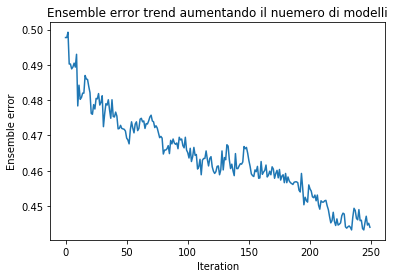

In [9]:
rs = RandomLinearModel()
a = AdaBoost(rs,250)
a.fit(X_train,y_train, False)

y_train_pred = a.predict(X_train)
y_test_pred = a.predict(X_test)

print("Training Set\n", "-" * 20)
print("Acc: %5f (Error: %5f)\n" % (accuracy_score(y_train, y_train_pred), calc_error(y_train, y_train_pred)))
print("Test Set\n", "-" * 20)
print("Acc: %5f (Error: %5f)\n" % (accuracy_score(y_test, y_test_pred), calc_error(y_test, y_test_pred)))

xs = np.arange(0, len(a.errors))
plt.plot(xs, a.errors)
plt.xlabel("Iteration")
plt.ylabel("Ensemble error")
plt.title("Ensemble error trend aumentando il nuemero di modelli")
plt.show()

3. Write few paragraphs about what you think about the experiment and about the results you obtained.

Possiamo notare che dopo varie iterazioni di AdaBoost, si ottiene un guadagno piccolo in termini di accuratezza.
Questo è dovuto all'uso di un modello inadeguato.
Quindi si può dire che un modello randomico non è capace di generalizzare.